In [133]:
import os.path
import pickle
import random

from wbtools.lib.nlp.text_preprocessing import get_documents_from_text
from sentence_transformers import SentenceTransformer, util
from matplotlib import pyplot as plt
import numpy as np
import random
import umap
from scipy import spatial

## Define constants

In [134]:
min_sentence_length = 20
max_corpus_size = 100000
use_cached_embeddings = False

## Read positive and negative sentences from file

In [135]:
def read_positive_sentences_from_file(filepath, min_sent_length=20):
    return [sentence for line in open(filepath) for sentence in get_documents_from_text(
        text=line.strip(), split_sentences=True) if len(sentence) > min_sent_length]

sent_expr_pattern = read_positive_sentences_from_file("../extracted_sentences/sentences_exp_pattern.txt",
                                                      min_sentence_length)
sent_subcellloc = read_positive_sentences_from_file("../extracted_sentences/sentences_exp_subcellloc.txt",
                                                    min_sentence_length)
neg_sent_otherxpr = [sent for sent in open("../extracted_sentences/neg_sentences_otherexpr.txt") if len(sent) >
                     min_sentence_length]

## Clean sentences

In [136]:
def clean_sentences(sentences):
    return list(set([sent.strip(' ').strip('.;,/-|').strip() for sent in sentences]))

sent_expr_pattern_clean = clean_sentences(sent_expr_pattern)
sent_subcellloc_clean = clean_sentences(sent_subcellloc)
neg_sent_otherxpr_clean = clean_sentences(neg_sent_otherxpr)

## Sample sentences

In [137]:
def get_random_sentence_subset(sentences, max_num_sentences):
    corpus = sentences
    random.shuffle(corpus)
    return corpus[0:max_num_sentences]

if use_cached_embeddings and os.path.exists("../sentence_embeddings/corpus_expr_pattern.txt") and os.path.exists("../sentence_embeddings/corpus_subcellloc.txt") and os.path.exists("../sentence_embeddings/corpus_neg_otherexpr.txt"):
    corpus_expr_pattern = [line.strip() for line in open("../sentence_embeddings/corpus_expr_pattern.txt")]
    corpus_expr_subcellloc = [line.strip() for line in open("../sentence_embeddings/corpus_subcellloc.txt")]
    corpus_neg_otherexpr = [line.strip() for line in open("../sentence_embeddings/corpus_neg_otherexpr.txt")]
else:
    corpus_expr_pattern = get_random_sentence_subset(sent_expr_pattern_clean, max_corpus_size)
    corpus_expr_subcellloc = get_random_sentence_subset(sent_subcellloc_clean, max_corpus_size)
    corpus_neg_otherexpr = get_random_sentence_subset(neg_sent_otherxpr_clean, max_corpus_size)
    with open("../sentence_embeddings/corpus_expr_pattern.txt", "w") as corpus_expr_pattern_file:
        for sent in corpus_expr_pattern:
            corpus_expr_pattern_file.write(sent + "\n")
    with open("../sentence_embeddings/corpus_subcellloc.txt", "w") as corpus_expr_subcellloc_file:
        for sent in corpus_expr_subcellloc:
            corpus_expr_subcellloc_file.write("sent" + "\n")
    with open("../sentence_embeddings/corpus_neg_otherexpr.txt", "w") as corpus_neg_otherexpr_file:
        for sent in corpus_neg_otherexpr:
            corpus_neg_otherexpr_file.write("sent" + "\n")

## Extract sentence embeddings with SBERT

In [138]:
if use_cached_embeddings and os.path.exists("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle") and os.path.exists("../sentence_embeddings/corpus_embeddings_subcellloc.pickle") and os.path.exists("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle"):
    corpus_embeddings_expr_pattern = pickle.load(open("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle", "rb"))
    corpus_embeddings_subcellloc = pickle.load(open("../sentence_embeddings/corpus_embeddings_subcellloc.pickle", "rb"))
    corpus_embeddings_neg_otherexpr = pickle.load(open("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle", "rb"))
else:
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    corpus_embeddings_expr_pattern = embedder.encode(corpus_expr_pattern, convert_to_tensor=True)
    corpus_embeddings_subcellloc = embedder.encode(corpus_expr_subcellloc, convert_to_tensor=True)
    corpus_embeddings_neg_otherexpr = embedder.encode(corpus_neg_otherexpr, convert_to_tensor=True)
    pickle.dump(corpus_embeddings_expr_pattern, open("../sentence_embeddings/corpus_embeddings_expr_pattern.pickle", "wb"))
    pickle.dump(corpus_embeddings_subcellloc, open("../sentence_embeddings/corpus_embeddings_subcellloc.pickle", "wb"))
    pickle.dump(corpus_embeddings_neg_otherexpr, open("../sentence_embeddings/corpus_embeddings_neg_otherexpr.pickle", "wb"))

## Use UMAP to obtain a dataset that can be visualized in 2d

In [171]:
umap_reducer = umap.UMAP(metric='cosine')
corpus_embeddings_expr_pattern_2d = umap_reducer.fit_transform(corpus_embeddings_expr_pattern)
corpus_embeddings_subcellloc_2d = umap_reducer.fit_transform(corpus_embeddings_subcellloc)
corpus_embeddings_neg_otherexpr_2d = umap_reducer.fit_transform(corpus_embeddings_neg_otherexpr)

In [172]:
colors = ['g'] * len(corpus_embeddings_expr_pattern_2d) + ['y'] * len(corpus_embeddings_subcellloc_2d) + ['b'] * len(corpus_embeddings_neg_otherexpr_2d)

In [173]:
all_corpora_2d = np.vstack((corpus_embeddings_expr_pattern_2d, corpus_embeddings_subcellloc_2d, corpus_embeddings_neg_otherexpr_2d))

## UMAP visualization with different colors for each sentence category
expr_pattern = green
subcellloc = yellow
negative = blue

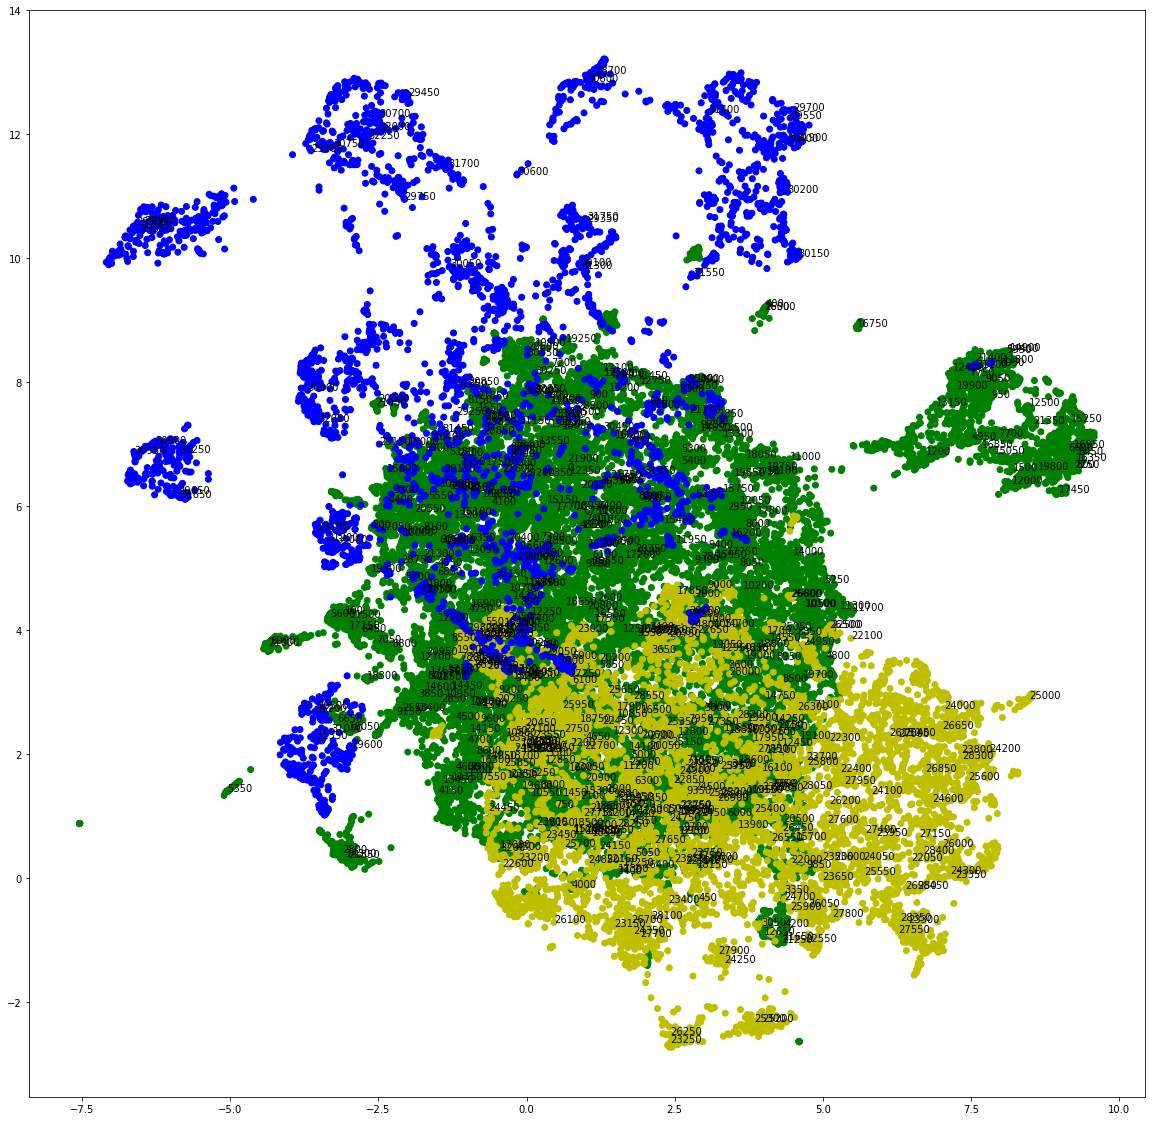

In [174]:
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(all_corpora_2d[:,0]), y=list(all_corpora_2d[:,1]), c=colors)
for i in range(len(all_corpora_2d)):
    if i % 50 == 0:
        plt.annotate(str(i), (all_corpora_2d[i,0], all_corpora_2d[i,1]))

In [176]:
corpus_neg_otherexpr[30950 - len(corpus_expr_pattern) - len(corpus_expr_subcellloc)]

'To further demonstrate ER stress was induced by myristoylation deﬁciency, we also examined the activity of PEK-1/PERK.'

In [177]:
corpus_neg_otherexpr[30000 - len(corpus_expr_pattern) - len(corpus_expr_subcellloc)]

'We further tested the epistasis relationship between overexpression of xbp-1s, which reduces ER stress (Shen et al, 2001; Taylor and Dillin, 2013) and suppresses the paralysis phenotype in myristoylation-deﬁcient animals (Figure 5G), and muscle-speciﬁc overexpression of the eIF-2a(S49D) phosphomimetic transgene, which causes the paralysis and muscle defects in wild type (Figures 6A–6D).'

In [145]:
best_matches = util.semantic_search(query_embeddings=corpus_embeddings_neg_otherexpr, corpus_embeddings=corpus_embeddings_expr_pattern)

In [167]:
[(i, corpus_id_score_dict) for i, values in enumerate(best_matches) for corpus_id_score_dict in values if corpus_id_score_dict['score'] > 0.8]

[(345, {'corpus_id': 16703, 'score': 0.8006513118743896}),
 (629, {'corpus_id': 1359, 'score': 0.8135823011398315}),
 (817, {'corpus_id': 1969, 'score': 0.8111934661865234}),
 (1188, {'corpus_id': 9780, 'score': 0.9096450805664062}),
 (2130, {'corpus_id': 1969, 'score': 0.8025082945823669})]

In [168]:
corpus_neg_otherexpr[345]

'GFP::LGG-1  labels pre-autophagosomal and autophagosomal structures.'

In [169]:
corpus_expr_pattern[16703]

'Together these data show that lgg-1 and lgg-2 present widely overlapping expression patterns and suggests the presence of numerous autophagosomal structures during embryogenesis'

In [170]:
1 - spatial.distance.cosine(corpus_embeddings_neg_otherexpr[345], corpus_embeddings_expr_pattern[16703])

0.8006511926651001